The scripts below demonstrate how to use EPCOT to predict epigenomic features, CAGE-seq, chromatin contact maps, and enhancer activity.

We run EPCOT on Google Colab notebook under GPU setting : Runtime -> Change runtime type -> select GPU

In [1]:
!pip install kipoiseq==0.5.2 --quiet > /dev/null
!pip install einops
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# clone our GitHub repo
!git clone https://github.com/liu-bioinfo-lab/EPCOT.git
!mkdir models

Cloning into 'EPCOT'...
remote: Enumerating objects: 1089, done.
remote: Counting objects: 100% (295/295), done.
remote: Compressing objects: 100% (129/129), done.
remote: Total 1089 (delta 175), reused 272 (delta 163), pack-reused 794
Receiving objects: 100% (1089/1089), 72.48 MiB | 13.00 MiB/s, done.
Resolving deltas: 100% (216/216), done.
Checking out files: 100% (752/752), done.


In [3]:
import kipoiseq
from kipoiseq import Interval
import pyfaidx
import pandas as pd
import numpy as np
from scipy.sparse import load_npz
import torch
import sys,os
import matplotlib.pyplot as plt
sys.path.append('EPCOT/')
from usage_util import *

### Download and index reference genome file

In [4]:
# The following codes are copied from https://github.com/deepmind/deepmind-research/blob/master/enformer/enformer-usage.ipynb
fasta_file = '/root/data/genome.fa'
!mkdir -p /root/data
!wget -O - http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz | gunzip -c > {fasta_file}
pyfaidx.Faidx(fasta_file)
!ls /root/data
class FastaStringExtractor:
    def __init__(self, fasta_file):
        self.fasta = pyfaidx.Fasta(fasta_file)
        self._chromosome_sizes = {k: len(v) for k, v in self.fasta.items()}

    def extract(self, interval: Interval, **kwargs) -> str:
        # Truncate interval if it extends beyond the chromosome lengths.
        chromosome_length = self._chromosome_sizes[interval.chrom]
        trimmed_interval = Interval(interval.chrom,
                                    max(interval.start, 0),
                                    min(interval.end, chromosome_length),
                                    )
        # pyfaidx wants a 1-based interval
        sequence = str(self.fasta.get_seq(trimmed_interval.chrom,
                                          trimmed_interval.start + 1,
                                          trimmed_interval.stop).seq).upper()
        # Fill truncated values with N's.
        pad_upstream = 'N' * max(-interval.start, 0)
        pad_downstream = 'N' * max(interval.end - chromosome_length, 0)
        return pad_upstream + sequence + pad_downstream

    def close(self):
        return self.fasta.close()
fasta_extractor = FastaStringExtractor(fasta_file)

--2022-06-21 02:53:10--  http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz
Resolving hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 983659424 (938M) [application/x-gzip]
Saving to: ‘STDOUT’

-                   100%[===================>] 938.09M  19.2MB/s    in 54s     

2022-06-21 02:54:05 (17.3 MB/s) - written to stdout [983659424/983659424]

genome.fa  genome.fa.fai


### Prepare example input DNase-seq of GM12878

In [5]:
# load GM12878 DNase-seq in chromosome 11
GM12878_dnase=load_npz('EPCOT/examples/GM12878_dnase_chr11.npz').toarray().squeeze()
GM12878_dnase.shape

(135086000,)

### Download and load pre-training model

In [7]:
# Download model from google drive
!gdown 1_YfpNSv-2ABQV2qSyBxem-y7aJFyRNzz --output models/pretrain_dnase.pt

# we also provide pre-training models trained on ATAC-seq 
# !gdown 1aMb3kVmaWZPUzqKmfZs9xWT-QLUGjQQd --output models/pretrain_atac.pt

Downloading...
From: https://drive.google.com/uc?id=1_YfpNSv-2ABQV2qSyBxem-y7aJFyRNzz
To: /content/models/pretrain_dnase.pt
100% 100M/100M [00:01<00:00, 77.9MB/s] 


In [12]:
# arguments for pre-training model
import argparse
def parser_args():
    parser = argparse.ArgumentParser(add_help=False)
    parser.add_argument('--num_class', default=245, type=int)
    parser.add_argument('--seq_length', default=1600, type=int)
    parser.add_argument('--embedsize', default=320, type=int)
    parser.add_argument('--nheads', default=4, type=int)
    parser.add_argument('--hidden_dim', default=512, type=int)
    parser.add_argument('--dim_feedforward', default=1024, type=int)
    parser.add_argument('--enc_layers', default=1, type=int)
    parser.add_argument('--dec_layers', default=2, type=int)
    parser.add_argument('--dropout', default=0.2, type=float)
    parser.add_argument('--fea_pos', default=False, action='store_true')
    parser.add_argument('--load_backbone', default=False)
    args, unknown = parser.parse_known_args()
    return args,parser
def get_args():
    args,_ = parser_args()
    return args,_

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
import sys
from pretraining.model import build_model
args,parser = get_args()
pretrain_model= build_model(args)
pretrain_model.to(device)
#load pre-training model
pretrain_model.load_state_dict(torch.load('models/pretrain_dnase.pt'))


cuda:0


<All keys matched successfully>

### Make epigenomic feature prediction and plot results (EFP task)

In [13]:
#region of interest, the start and end position should be divisible by 1000
chrom,start,end=['chr11',46750000,47750000]
pred_score_epi=predict_epis(pretrain_model,chrom, start,end,GM12878_dnase,fasta_extractor,device)
pred_score_epi.shape

(1000, 245)

CTCF


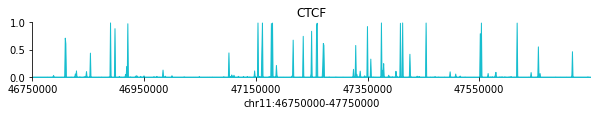

In [14]:
# a list of epigenome features predicted by EPCOT
with open('EPCOT/Profiles/epigenomes.txt', 'r') as f:
    epigenomes = f.read().splitlines()
#plot results
epi_idx=0
print(epigenomes[epi_idx])
fig,ax=plt.subplots(figsize=(10,1))
val=pred_score_epi[:,0]
plot_bindings(ax,val, chrom,start,end)
ax.set_title(epigenomes[epi_idx])
ax.set_xlabel('%s:%s-%s'%(chrom,start,end))
plt.show()

### Load Downstream model to predict CAGE-seq (CAGE-seq GEP task)

The downstream model to predict 1kb-resolution CAGE-seq takes the input of 250kb genomic regions and predicts the CAGE-seq in the centered 200kb region.

In [15]:
# Download model from google drive
!gdown 1eP-ruOcywlGeQIRuVwWk_QFc4z9j4-jF --output models/cage_transformer.pt

Downloading...
From: https://drive.google.com/uc?id=1eP-ruOcywlGeQIRuVwWk_QFc4z9j4-jF
To: /content/models/cage_transformer.pt
100% 119M/119M [00:01<00:00, 62.7MB/s]


In [66]:
# arguments for CAGE-seq downstream model
import sys
sys.path.append('EPCOT/GEP/')
from cage.model import build_pretrain_model_cage
_,parser = parser_args()
def parser_args_cage(parent_parser):
    parser=argparse.ArgumentParser(parents=[parent_parser])
    parser.add_argument('--bins', type=int, default=250)
    parser.add_argument('--crop', type=int, default=25)
    parser.add_argument('--pretrain_path', type=str, default='none')
    parser.add_argument('--embed_dim', default=360, type=int)
    parser.add_argument('--mode', type=str, default='transformer')
    parser.add_argument('--fine_tune', default=False, action='store_true')
    args, unknown = parser.parse_known_args()
    return args

args=parser_args_cage(parser)
cage_model= build_pretrain_model_cage(args)
cage_model.to(device)

# load trained model
cage_model.load_state_dict(torch.load('models/cage_transformer.pt'))

# enter region of interest ('cage_end-cage_start' should be divisible by 200000)
cage_chrom,cage_start,cage_end=['chr11',46750000,47750000]
pred_cage=predict_cage(cage_model,cage_chrom,cage_start,cage_end,GM12878_dnase,fasta_extractor,device)
pred_cage.shape

(1000,)

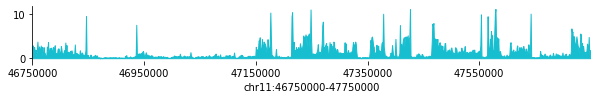

In [67]:
# plot results
fig,ax=plt.subplots(figsize=(10,1))
plot_cage(ax,pred_cage,cage_chrom,cage_start,cage_end)
plt.show()

## Hi-C chromatin contact map prediction (Hi-C COP task)

In [32]:
# Download models trained on GM12878
!gdown 1EXm2AjqqO-UtLi2pprbDEb1gPXrxI3aW --output models/hic_GM12878_transformer.pt

Downloading...
From: https://drive.google.com/uc?id=1EXm2AjqqO-UtLi2pprbDEb1gPXrxI3aW
To: /content/models/hic_GM12878_transformer.pt
100% 119M/119M [00:00<00:00, 332MB/s]


In [43]:
# arguments for hic downstream model
import sys
sys.path.append('EPCOT/COP/')
from hic.model import build_pretrain_model_hic
_,parser = parser_args()
def parser_args_hic(parent_parser):
    parser=argparse.ArgumentParser(parents=[parent_parser])
    parser.add_argument('--bins', type=int, default=200)
    parser.add_argument('--crop', type=int, default=4)
    parser.add_argument('--pretrain_path', type=str, default='none')
    parser.add_argument('--embed_dim', default=256, type=int)
    parser.add_argument('--trunk',  type=str, default='transformer')
    parser.add_argument('--fine_tune', default=False, action='store_true')
    args, unknown = parser.parse_known_args()
    return args
hic_args=parser_args_hic(parser)
hic_model= build_pretrain_model_hic(hic_args)
hic_model.cuda()

# load GM12878 model
hic_model.load_state_dict(torch.load('models/hic_GM12878_transformer.pt'))

61


<All keys matched successfully>

In [26]:
# regions of interest, where 'hic_end-hic_start' should be divisible by 1000000 (recomand to input a 1Mb region at one time)
# the output is an array of the upper triangular of the contact matrix
hic_chrom,hic_start,hic_end=['chr11',46750000,47750000]
pred_hic=predict_hic(hic_model,hic_chrom,hic_start,hic_end,GM12878_dnase,fasta_extractor,device)
pred_hic.shape

(1, 18528, 1)

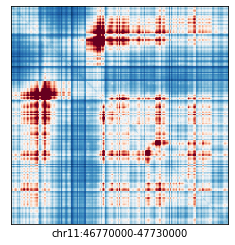

In [30]:
# convert the upper triangular array into a contact matrix
pred_hic_mat=complete_mat(arraytouptri(pred_hic[0].squeeze(),args))
fig,ax=plt.subplots()
plot_hic(ax,pred_hic_mat)
ax.set_xlabel('%s:%s-%s'%(hic_chrom,hic_start+20000,hic_end-20000))
plt.show()

##Visualize results above in one plot

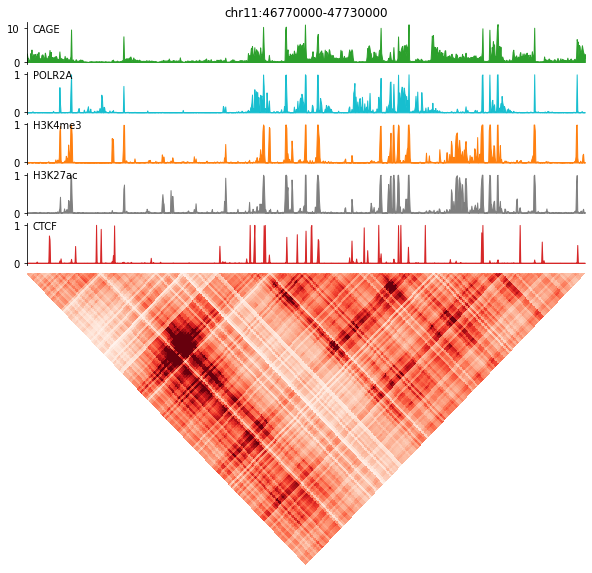

In [31]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(11, 5)

ax_hic = fig.add_subplot(gs[5:11, :5])
axs = [fig.add_subplot(gs[i,:5]) for i in range(5)]
bin_coords = np.true_divide(np.arange(192), np.sqrt(2))
x, y = np.meshgrid(bin_coords, bin_coords)
sin45 = np.sin(np.radians(45))
x, y = x * sin45 + y * sin45, x * sin45 - y * sin45
ax_hic.pcolormesh(x, y, pred_hic_mat, cmap='Reds', vmin=0, vmax=5)
ax_hic.set_ylim(-96,0)
cage=pred_cage[20:-20]
axs[0].fill_between(np.arange(cage.shape[0]), 0, cage, color='#2ca02c')
axs[0].text(10,9,'CAGE', ha='left')
val=pred_score_epi[:,7][20:-20]
axs[1].fill_between(np.arange(val.shape[0]), 0, val, color='#17becf')
axs[1].text(10,0.9,'POLR2A', ha='left')
val=pred_score_epi[:,-3][20:-20]
axs[2].fill_between(np.arange(val.shape[0]), 0, val,color='#ff7f0e')
axs[2].text(10,0.9,'H3K4me3', ha='left')
val = pred_score_epi[:, -6][20:-20]
axs[3].fill_between(np.arange(val.shape[0]), 0, val, color='#7f7f7f')
axs[3].text(10,0.9,'H3K27ac', ha='left')
val = pred_score_epi[:, 0][20:-20]
axs[4].fill_between(np.arange(val.shape[0]), 0, val, color='#d62728')
axs[4].text(10,0.9,'CTCF', ha='left')
for ax in axs:
    ax.margins(x=0)
    ax.set_xticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
ax_hic.axis('off')
axs[0].set_title('%s:%s-%s'%(hic_chrom,hic_start+20000,hic_end-20000))
plt.show()

## Cross-cell type prediction in HCT116

For cross-cell type prediction, it is important that the normalized DNase-seq in training cell types and testing cell types have similar data scales, if not, maybe some normalization methods are needed.

In [33]:
# In addition to Hi-C model trained on  GM12878, we have other models trained on IMR-90, HFF, transverse colon's Hi-C with inputs of DNase
# These models are trained on DNase-seq with different experiments or platform, you can choose models to predict for your own inputs
!gdown 1ia-ZoSoiZGDFPnZcySzMpirovHhulRfH --output models/hic_HFF_transformer.pt
!gdown 1ofkpS526gXpnusGpRWVHgIFFFpTSW4Rm --output models/hic_IMR-90_transformer.pt
!gdown 1OtWkTLuYad3iRPuGy5OCewNGPlr47ogA --output models/hic_trans_colon_m37_transformer.pt

# we also provide models trained on ATAC-seq
# !gdown 1Lyfpn9YOscMbYCp79F3BDrlOSX77Q_P_ --output models/GM12878_hic_atac.pt
# !gdown 1L6Woz9gqZa_bkuZFJj3FzJ41RW79zSav --output trans_colon_m37_hic_atac.pt

Downloading...
From: https://drive.google.com/uc?id=1ia-ZoSoiZGDFPnZcySzMpirovHhulRfH
To: /content/models/hic_HFF_transformer.pt
100% 119M/119M [00:00<00:00, 250MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ofkpS526gXpnusGpRWVHgIFFFpTSW4Rm
To: /content/models/hic_IMR-90_transformer.pt
100% 119M/119M [00:00<00:00, 320MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1OtWkTLuYad3iRPuGy5OCewNGPlr47ogA
To: /content/models/hic_trans_colon_m37_transformer.pt
100% 119M/119M [00:00<00:00, 349MB/s] 


In [44]:
# Hi-C cross-cell type predicition
# load models trained on GM12878 and IMR-90, for other models you can also download them from google drives
hic_model_gm= build_pretrain_model_hic(hic_args)
hic_model_gm.cuda()
hic_model_gm.load_state_dict(torch.load('models/hic_GM12878_transformer.pt'))
hic_model_imr= build_pretrain_model_hic(hic_args)
hic_model_imr.cuda()
hic_model_imr.load_state_dict(torch.load('models/hic_IMR-90_transformer.pt'))

61
61


<All keys matched successfully>

In [35]:
# load HCT116's DNase-seq in chromosome 11
HCT116_dnase=load_npz('EPCOT/examples/HCT116_dnase_chr11.npz').toarray().squeeze()

In [36]:
# cross-cell type contact map prediction using ensemble of models trained on GM12878 and IMR-90
hic_chrom,hic_start,hic_end=['chr11',86750000,87750000]
pred_hic1=predict_hic(hic_model_gm,hic_chrom,hic_start,hic_end,HCT116_dnase,fasta_extractor,device)
pred_hic2=predict_hic(hic_model_imr,hic_chrom,hic_start,hic_end,HCT116_dnase,fasta_extractor,device)
pred_hic=(pred_hic1+pred_hic2)/2
pred_hic_mat=complete_mat(arraytouptri(pred_hic[0].squeeze(),args))

# cross-cell type epigenomic feature prediction
# region of interest
chrom,start,end=['chr11',86770000,87730000]
pred_epi= predict_epis(pretrain_model,chrom,start,end,HCT116_dnase,fasta_extractor,device)

# Cross-cell type CAGE-seq prediction
cage_chrom,cage_start,cage_end=['chr11',86750000,87750000]
pred_cage= predict_cage(cage_model,cage_chrom,cage_start,cage_end,HCT116_dnase,fasta_extractor,device)

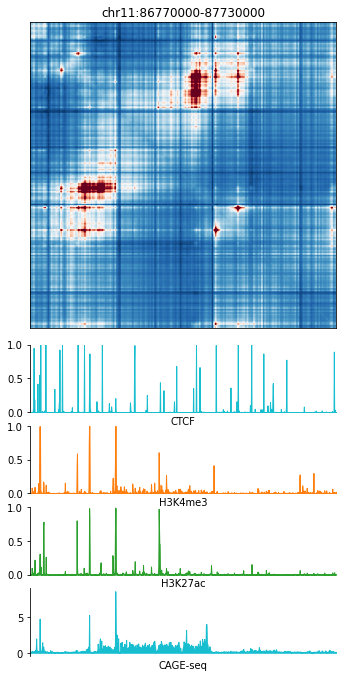

In [37]:
# plot results
fig = plt.figure(figsize=(5, 9.5))
gs = GridSpec(8, 5, wspace = 0.75, hspace = 0.2, left = 0.05, top = 0.98, right = 0.9, bottom = 0.05)
ax_hic = fig.add_subplot(gs[:4, :5])
ax_track= [fig.add_subplot(gs[4+i:5+i,:5]) for i in range(4)]
plot_hic(ax_hic,pred_hic_mat,vmin=0,vmax=4)
epis=['CTCF','H3K4me3','H3K27ac','CAGE-seq']
plot_bindings(ax_track[0],pred_epi[:,0], chrom,start,end)
plot_bindings(ax_track[1],pred_epi[:,-3], chrom,start,end,color='tab:orange')
plot_bindings(ax_track[2],pred_epi[:,-6], chrom,start,end,color='tab:green')
plot_cage(ax_track[3],pred_cage[20:-20],cage_chrom,cage_start,cage_end)
for i in range(len(ax_track)):
  ax_track[i].set_xticks([])
  ax_track[i].set_xlabel(epis[i])
ax_hic.set_title('%s:%s-%s'%(chrom,start,end))
plt.show()


## Cross-cell type prediction in HUVEC

In [52]:
# load HUVEC's DNase-seq in chromosome 11
HUVEC_dnase=load_npz('EPCOT/examples/HUVEC_dnase_chr11.npz').toarray().squeeze()
HUVEC_dnase.shape

(135086000,)

In [51]:
# cross-cell type contact map prediction using ensemble of models trained on GM12878 and IMR-90
hic_chrom,hic_start,hic_end=['chr11',86750000,87750000]
pred_hic1=predict_hic(hic_model_gm,hic_chrom,hic_start,hic_end,HUVEC_dnase,fasta_extractor,device)
pred_hic2=predict_hic(hic_model_imr,hic_chrom,hic_start,hic_end,HUVEC_dnase,fasta_extractor,device)
pred_hic=(pred_hic1+pred_hic2)/2
pred_hic_mat=complete_mat(arraytouptri(pred_hic[0].squeeze(),args))

# cross-cell type epigenomic feature prediction
# region of interest
chrom,start,end=['chr11',86770000,87730000]
pred_epi= predict_epis(pretrain_model,chrom,start,end,HUVEC_dnase,fasta_extractor,device)

# Cross-cell type CAGE-seq prediction
cage_chrom,cage_start,cage_end=['chr11',86750000,87750000]
pred_cage= predict_cage(cage_model,cage_chrom,cage_start,cage_end,HUVEC_dnase,fasta_extractor,device)

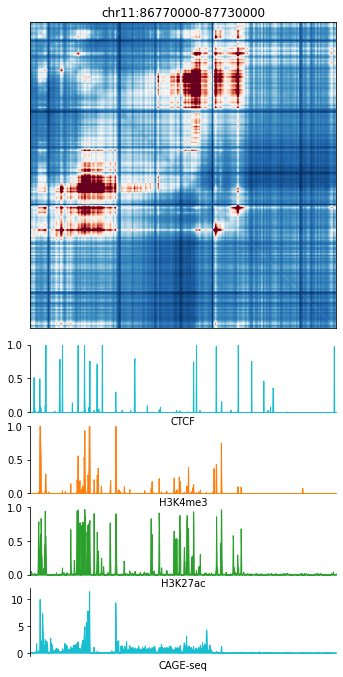

In [41]:
# plot results
fig = plt.figure(figsize=(5, 9.5))
gs = GridSpec(8, 5, wspace = 0.75, hspace = 0.2, left = 0.05, top = 0.98, right = 0.9, bottom = 0.05)
ax_hic = fig.add_subplot(gs[:4, :5])
ax_track= [fig.add_subplot(gs[4+i:5+i,:5]) for i in range(4)]
plot_hic(ax_hic,pred_hic_mat,vmin=0,vmax=4)
epis=['CTCF','H3K4me3','H3K27ac','CAGE-seq']
plot_bindings(ax_track[0],pred_epi[:,0], chrom,start,end)
plot_bindings(ax_track[1],pred_epi[:,-3], chrom,start,end,color='tab:orange')
plot_bindings(ax_track[2],pred_epi[:,-6], chrom,start,end,color='tab:green')
plot_cage(ax_track[3],pred_cage[20:-20],cage_chrom,cage_start,cage_end)
for i in range(len(ax_track)):
  ax_track[i].set_xticks([])
  ax_track[i].set_xlabel(epis[i])
ax_hic.set_title('%s:%s-%s'%(chrom,start,end))
plt.show()


## Cross-tissue type prediction in GTEx tissue donors

In [42]:
# download DNase-seq of stomach tissue (female 53 years)
!gdown 1MWZEktc6OjX2staP2YDtYafFnWHv5afm --output stomach_f53_dnase.pickle

Downloading...
From: https://drive.google.com/uc?id=1MWZEktc6OjX2staP2YDtYafFnWHv5afm
To: /content/stomach_f53_dnase.pickle
100% 893M/893M [00:14<00:00, 62.4MB/s]


In [61]:
import pickle
hic_chrom,hic_start,hic_end=['chr11',7750000,8750000]
with open('stomach_f53_dnase.pickle','rb') as f:
    stomach_tmp_dnase=pickle.load(f)
stomach_dnase=stomach_tmp_dnase[int(hic_chrom[3:])].toarray().squeeze()
stomach_dnase.shape

(135086000,)

In [62]:
# cross-tissue type contact map prediction using model trained on transverse colon (male 37 years)
hic_model= build_pretrain_model_hic(hic_args)
hic_model.cuda()
hic_model.load_state_dict(torch.load('models/hic_trans_colon_m37_transformer.pt'))
pred_hic=predict_hic(hic_model,hic_chrom,hic_start,hic_end,stomach_dnase,fasta_extractor,device)
pred_hic_mat=complete_mat(arraytouptri(pred_hic[0].squeeze(),args))

# cross-tissue type epigenomic feature prediction
# region of interest
chrom,start,end=['chr11',7770000,8730000]
pred_epi= predict_epis(pretrain_model,chrom,start,end,stomach_dnase,fasta_extractor,device)

61


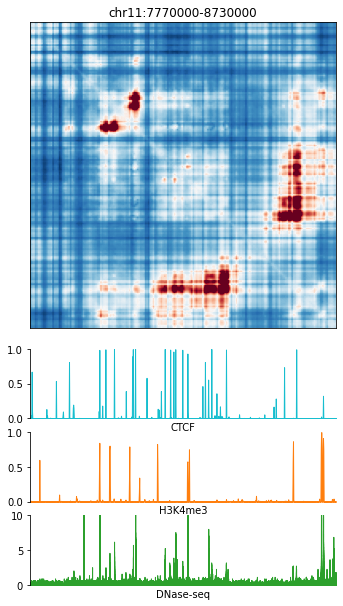

In [68]:
fig = plt.figure(figsize=(5, 8.5))
gs = GridSpec(7, 5, wspace = 0.75, hspace = 0.2, left = 0.05, top = 0.98, right = 0.9, bottom = 0.05)
ax_hic = fig.add_subplot(gs[:4, :5])
ax_track= [fig.add_subplot(gs[4+i:5+i,:5]) for i in range(3)]
plot_hic(ax_hic,pred_hic_mat,vmin=0,vmax=3)
epis=['CTCF','H3K4me3','DNase-seq']
plot_bindings(ax_track[0],pred_epi[:,0], chrom,start,end)
plot_bindings(ax_track[1],pred_epi[:,-3], chrom,start,end,color='tab:orange')
plot_cage(ax_track[2],stomach_dnase[start:end],chrom,start,end,color='tab:green')
ax_track[2].set_ylim(0,10)
for i in range(len(ax_track)):
  ax_track[i].set_xticks([])
  ax_track[i].set_xlabel(epis[i])
ax_hic.set_title('%s:%s-%s'%(chrom,start,end))
plt.show()